In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# import clean data for collisions at fault
data = pd.read_parquet('at_fault_collisions.parquet')


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1401155 entries, 0 to 3082219
Data columns (total 48 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   CASE_ID               1401155 non-null  int64   
 1   PARTY_SEX             1401155 non-null  category
 2   PARTY_AGE             1401155 non-null  int64   
 3   PARTY_SOBRIETY        1401155 non-null  category
 4   PARTY_DRUG_PHYSICAL   1401155 non-null  category
 5   DIR_OF_TRAVEL         1401155 non-null  category
 6   PARTY_SAFETY_EQUIP_1  1401155 non-null  category
 7   PARTY_SAFETY_EQUIP_2  1401155 non-null  category
 8   FINAN_RESPONS         1401155 non-null  category
 9   SP_INFO_2             1401155 non-null  category
 10  OAF_VIOL_CAT          1401155 non-null  category
 11  OAF_1                 1401155 non-null  category
 12  MOVE_PRE_ACC          1401155 non-null  category
 13  VEHICLE_YEAR          1401155 non-null  int64   
 14  VEHICLE_MAKE          1

#### Feature Selection

In [4]:
# drop columns not needed based on data visualizations
cols_to_drop = ['CASE_ID','PARTY_SAFETY_EQUIP_2','SP_INFO_2','OAF_1','BEAT_TYPE',
                'CHP_VEH_TYPE_TOWING','PRIMARY_COLL_FACTOR', 'DIRECTION']

data = data.drop(cols_to_drop, axis = 1)


In [5]:
# reset index
data = data.reset_index(drop = True)


#### Data Preprocessing
Since feature importance is a large area of interest, categorical values will not be one hot encoded. Random Forest and Gradient Boosting handle categorical and numeric features very well. At this point, I decided to keep 'Not Stated' values in the target because it would be interesting to see if there is any correlation of a PCF category not being stated to any of the features.

In [6]:
# scale numerical data

# make copy of data for preprocessing
scaled_data = data.copy()

# select numeric dtypes
num_cols = scaled_data.select_dtypes(include = ['float64', 'int64']).columns

scaler = StandardScaler()

# fit and transform selected data
data_scaled = scaler.fit_transform(scaled_data[num_cols])

# replace numeric columns with scaled columns
scaled_data[num_cols] = data_scaled


In [7]:
# label encode categorical columns

# select categorical dtypes
cat_cols = scaled_data.select_dtypes(include = ['category']).columns

encoder_mappings = {}

# fit and transform
for col in cat_cols:
    encoder = LabelEncoder()
    scaled_data[col] = encoder.fit_transform(scaled_data[col])
    #save mapping of encoded values
    encoder_mappings[col] = encoder.classes_
    
processed_data = scaled_data.copy()


In [8]:
# check mapping
encoder_mappings['PCF_VIOL_CATEGORY'][20]


'Not Stated'

In [10]:
# create target and features
y = processed_data['PCF_VIOL_CATEGORY']
X = processed_data.drop('PCF_VIOL_CATEGORY', axis = 1)


In [9]:
# check for class imbalance
class_distribution = processed_data['PCF_VIOL_CATEGORY'].value_counts()
print(class_distribution)

class_percentage = processed_data['PCF_VIOL_CATEGORY'].value_counts(normalize=True) * 100
print(class_percentage)

PCF_VIOL_CATEGORY
3     531007
8     314758
1     148524
9     124753
7     113330
12     56953
18     35439
5      18078
4      14552
6      11209
17      8696
10      7531
19      5552
0       4068
16      2036
13      1753
20      1725
2        803
11       263
15        80
14        45
Name: count, dtype: int64
PCF_VIOL_CATEGORY
3     37.897806
8     22.464181
1     10.600112
9      8.903583
7      8.088327
12     4.064718
18     2.529270
5      1.290221
4      1.038572
6      0.799983
17     0.620631
10     0.537485
19     0.396245
0      0.290332
16     0.145309
13     0.125111
20     0.123113
2      0.057310
11     0.018770
15     0.005710
14     0.003212
Name: proportion, dtype: float64


There is a class imbalance that has to be taken into consideration when looking at the metrics for each model. I attempted to resample the data to balance the classes but that resulted in a low performing model. 

In [11]:
# balance features and target by resampling
#rus = RandomUnderSampler(random_state=42)

#X_new, y_new = rus.fit_resample(X, y)

In [13]:
# check class balance
#class_distribution = y_new.value_counts()
#print(class_distribution)

#class_percentage = y_new.value_counts(normalize=True) * 100
#print(class_percentage)

In [12]:
# split data, random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42) 

## Baseline Model Selection

### Random Forest Classifier

In [14]:
# instanciate object
rfc_model = RandomForestClassifier(random_state = 42)

# fit data
rfc_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
preds = rfc_model.predict(X_test)

In [19]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average = 'weighted', zero_division=1)
recall = recall_score(y_test, preds, average = 'weighted', zero_division=1)
f1 = f1_score(y_test, preds, average = 'weighted', zero_division=1)

print(f'Random Forest: \n Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n F1: {f1}')

Random Forest: 
 Accuracy: 0.8418055104538755 
 Precision: 0.8358022893915624 
 Recall: 0.8418055104538755 
 F1: 0.830360741176589


In [20]:
conf_matx = confusion_matrix(y_test, preds)

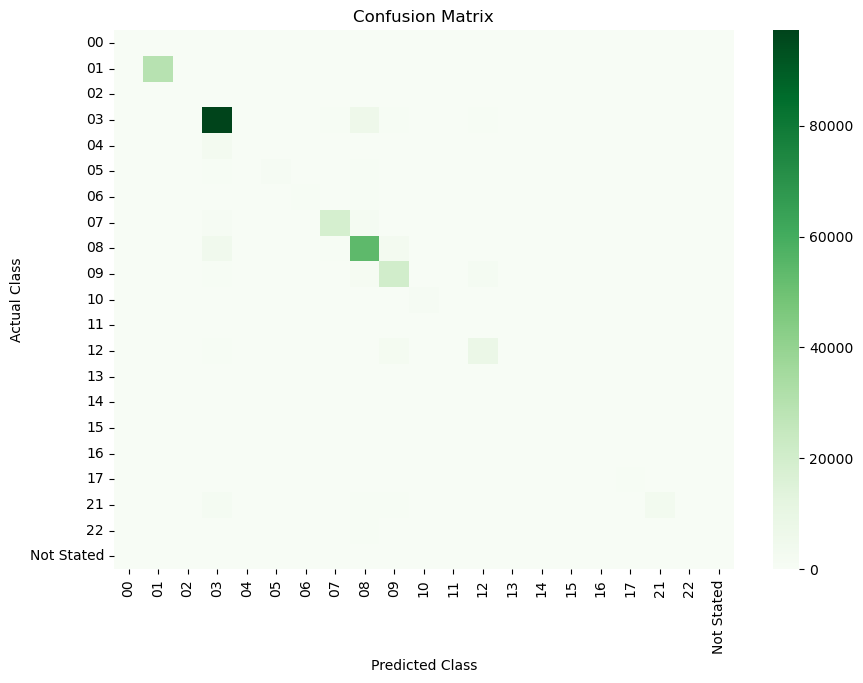

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Labels for the classes
class_names = ['00','01','02','03','04','05','06','07','08','09',
               '10','11','12','13','14','15','16','17','21','22','Not Stated'] 

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matx, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

### Gradient Boosting Classifier

In [ ]:
# instanciate object 
gb_clf = GradientBoostingClassifier(random_state = 42)

#fit model
gb_clf.fit(X_train, y_train)

### Voting Classifier

In [ ]:
# choose classifiers
clf1 = RandomForestClassifier(random_state = 42)
clf2 = GradientBoostingClassifier(random_state = 42)

# instanciate voting class
voting_clf = VotingClassifier(estimators = [('rfc', clf1), ('gbc', clf2)], voting='soft')

# fit model
voting_clf.fit(X_train, y_train)
